In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow
import os
import cv2
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import ResNet50
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input

In [3]:
!unzip '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms_1s_splitted.zip' -d "/content"
one_second_spectrograms = '/content/spectrograms_1s_splitted'

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/test/classical/classical.00066_clip24.png  
  inflating: /content/test/classical/classical.00066_clip25.png  
  inflating: /content/test/classical/classical.00066_clip26.png  
  inflating: /content/test/classical/classical.00066_clip27.png  
  inflating: /content/test/classical/classical.00066_clip28.png  
  inflating: /content/test/classical/classical.00066_clip29.png  
  inflating: /content/test/classical/classical.00066_clip3.png  
  inflating: /content/test/classical/classical.00066_clip4.png  
  inflating: /content/test/classical/classical.00066_clip5.png  
  inflating: /content/test/classical/classical.00066_clip6.png  
  inflating: /content/test/classical/classical.00066_clip7.png  
  inflating: /content/test/classical/classical.00066_clip8.png  
  inflating: /content/test/classical/classical.00066_clip9.png  
  inflating: /content/test/classical/classical.00067_clip0.png  
  inflating: /conte

## Split data

In [4]:
train_spectrograms_dir = '/content/train'
test_spectrograms_dir = '/content/test'

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  train_spectrograms_dir,
  label_mode='categorical',
  seed=123,
  image_size=(308, 465))

test_ds = tensorflow.keras.utils.image_dataset_from_directory(
  test_spectrograms_dir,
  label_mode='categorical',
  seed=123,
  image_size=(308, 465))

Found 23964 files belonging to 10 classes.
Found 5997 files belonging to 10 classes.


## Compile models

In [55]:
def resnet_compile(model, checkpoint_path):
  lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=1e-6)

  optimizer = RMSprop(learning_rate=lr_schedule)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  return model, checkpoint

def model_1_compile(model, checkpoint_path):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
  checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

  return model, reduce_lr, checkpoint, early_stopping

## Load models and fit

In [46]:
import shutil

def save_history(history):
  filename = f'{model._name}_history_split_1s.npy'
  np.save(filename, H.history)
  content_dir = "/content/" + filename
  checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/" + model._name
  shutil.copy(content_dir, checkpoint_dir)

### ResNet model

In [56]:
model = tensorflow.keras.models.load_model("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50/Model_ResNet50_best_model_original.h5")

checkpoint_path = os.path.join("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50", "Model_ResNet50_best_model_split_1s.h5")


model, checkpoint = resnet_compile(model, checkpoint_path)
H = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=[checkpoint])
save_history(H)

Epoch 1/10
749/749 [==============================] - ETA: 0s - loss: 1.4098 - accuracy: 0.5105
Epoch 1: val_accuracy improved from -inf to 0.56161, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50/Model_ResNet50_best_model_split_1s.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


749/749 [==============================] - 273s 360ms/step - loss: 1.4098 - accuracy: 0.5105 - val_loss: 1.2623 - val_accuracy: 0.5616
Epoch 2/10
749/749 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.6215
Epoch 2: val_accuracy improved from 0.56161 to 0.60113, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50/Model_ResNet50_best_model_split_1s.h5
749/749 [==============================] - 264s 351ms/step - loss: 1.1033 - accuracy: 0.6215 - val_loss: 1.1792 - val_accuracy: 0.6011
Epoch 3/10
749/749 [==============================] - ETA: 0s - loss: 1.0316 - accuracy: 0.6530
Epoch 3: val_accuracy improved from 0.60113 to 0.61114, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50/Model_ResNet50_best_model_split_1s.h5
749/749 [==============================] - 298s 398ms/step - loss: 1.0316 - accuracy: 0.6530 - val_loss: 1.1573 - val_accuracy: 0.6111
Epoch 4/10
749/749 [===============

### CNN Model_1

In [47]:
model = tensorflow.keras.models.load_model("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1/mel_best_model.h5")
checkpoint_path = os.path.join("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1", "Model_1_best_model_split_1s.h5")

model, reduce_lr, checkpoint, early_stopping = model_1_compile(model, checkpoint_path)
H = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=[checkpoint, reduce_lr, early_stopping])
save_history(H)

Epoch 1/10
749/749 [==============================] - ETA: 0s - loss: 1.5398 - accuracy: 0.4571
Epoch 1: val_accuracy improved from -inf to 0.49491, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1/Model_1_best_model_split_1s.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


749/749 [==============================] - 383s 508ms/step - loss: 1.5398 - accuracy: 0.4571 - val_loss: 1.4155 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 2/10
749/749 [==============================] - ETA: 0s - loss: 1.3096 - accuracy: 0.5376
Epoch 2: val_accuracy improved from 0.49491 to 0.52193, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1/Model_1_best_model_split_1s.h5
749/749 [==============================] - 376s 501ms/step - loss: 1.3096 - accuracy: 0.5376 - val_loss: 1.3584 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 3/10
749/749 [==============================] - ETA: 0s - loss: 1.1891 - accuracy: 0.5799
Epoch 3: val_accuracy improved from 0.52193 to 0.56078, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1/Model_1_best_model_split_1s.h5
749/749 [==============================] - 379s 506ms/step - loss: 1.1891 - accuracy: 0.5799 - val_loss: 1.2756 - val_accuracy: 0.5608 - lr: 0.0010
Epoch 4/10
749/749 [====

## Calculate metrics & plot

In [5]:
checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/"
models_dict = {}


for directory in os.listdir(checkpoint_dir):
  best_model_path = os.path.join(checkpoint_dir, directory)
  best_model = tensorflow.keras.models.load_model(best_model_path + "/" + directory + "_best_model_split_1s.h5")

  y_test_all = []
  y_pred_all = []

  for images, labels in test_ds:
    predict_results = best_model.predict(images, verbose=None)
    y_pred = np.argmax(predict_results, axis=1)
    y_pred_all.extend(y_pred)
    y_test_all.extend(labels.numpy())

  y_pred_all = np.array(y_pred_all)
  y_test_all = np.array(y_test_all)

  y_test_indices = np.argmax(y_test_all, axis=1) if y_test_all.ndim > 1 else y_test_all

  history = f"{checkpoint_dir}{directory}/{directory}_history_split_1s.npy"

  model_dict = {'y_pred': y_pred_all, 'y_test': y_test_indices, 'history': history}
  models_dict[str(directory)] = model_dict

In [6]:
spectogram_dir = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/mel_spectrograms'
classes = np.load(os.path.join(spectogram_dir, 'classes.npy'))

for model in models_dict:
  y_pred = models_dict.get(model).get('y_pred')
  y_test = models_dict.get(model).get('y_test')
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, target_names=classes)
  print(str(model) + " statistics")
  print(report)
  print(f'Accuracy: {accuracy:.4f}' + '\n')

Model_1 statistics
              precision    recall  f1-score   support

      reggae       0.56      0.43      0.49       600
       blues       0.74      0.88      0.81       598
       metal       0.48      0.32      0.38       600
     country       0.47      0.42      0.44       600
        rock       0.68      0.54      0.60       599
      hiphop       0.52      0.62      0.57       600
   classical       0.84      0.79      0.82       600
        jazz       0.50      0.72      0.59       600
       disco       0.43      0.47      0.45       600
         pop       0.41      0.43      0.42       600

    accuracy                           0.56      5997
   macro avg       0.56      0.56      0.56      5997
weighted avg       0.56      0.56      0.56      5997

Accuracy: 0.5621

Model_ResNet50 statistics
              precision    recall  f1-score   support

      reggae       0.54      0.60      0.57       600
       blues       0.81      0.86      0.83       598
       metal   

In [7]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history['accuracy'], label='Train Accuracy')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    ax2.plot(history['loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    fig.suptitle(model_name, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()

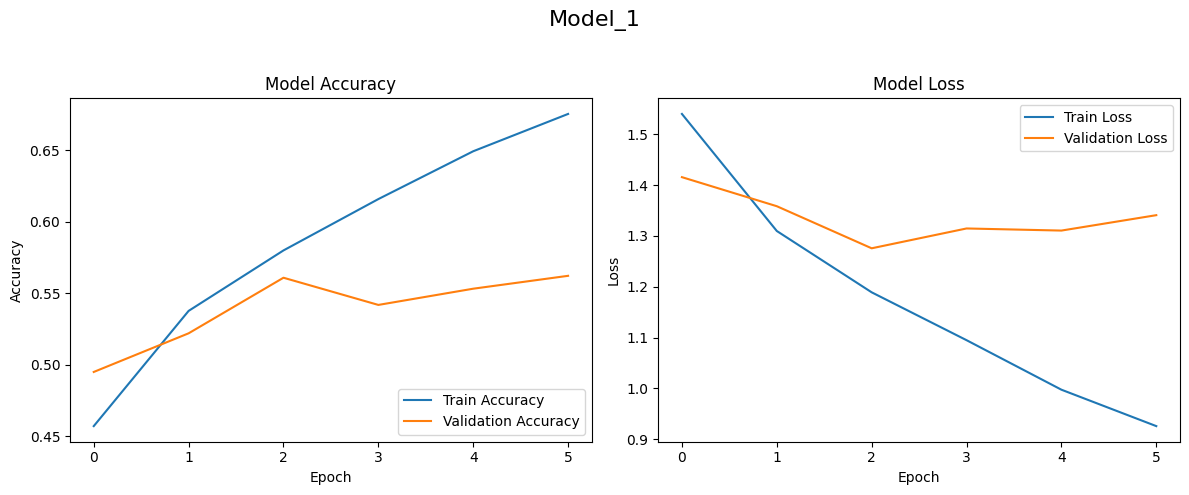

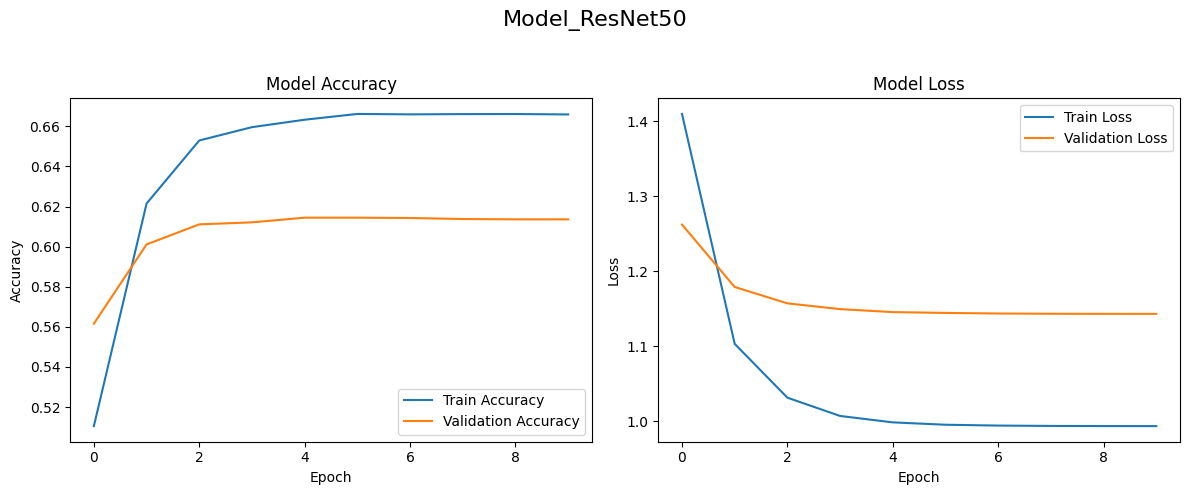

In [8]:
for model in models_dict:
  history = np.load(models_dict.get(model).get('history'), allow_pickle='TRUE').item()
  plot_history(history, model)